In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fine2coarse/MCN2_fine_to_coarse.txt


In [43]:
from datasets import load_dataset
# loading the dataset
ds = load_dataset("MultiCoNER/multiconer_v2", "Hindi (HI)")

In [44]:
df = ds['train'].to_pandas()

In [45]:
# Read the replacement mapping file
replacement_mapping = {}
with open('/kaggle/input/fine2coarse/MCN2_fine_to_coarse.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        original = parts[0]
        replacement = parts[1] if len(parts) > 1 else ''
        replacement_mapping[original] = replacement
        
df['coarse_tags'] = None

for index, row in df.iterrows():
    transformed_tags = []
    for tag in row['ner_tags']:
        new_tag = 'O'
        if(tag!='O'):
            prefix, entity = tag.split('-', 1)
            if entity in replacement_mapping:
                new_entity = replacement_mapping[entity]
                if new_entity:
                    new_tag = f"{prefix}-{new_entity}"
        transformed_tags.append(new_tag)
    df.at[index, 'coarse_tags'] = transformed_tags

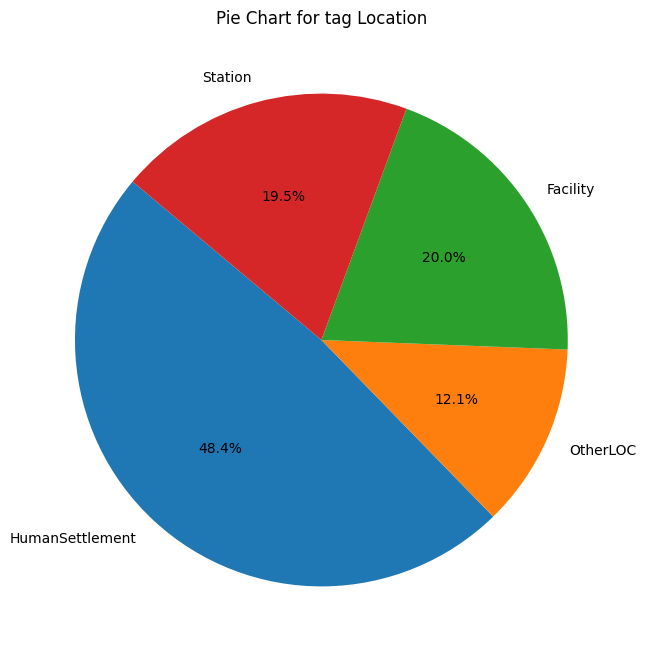

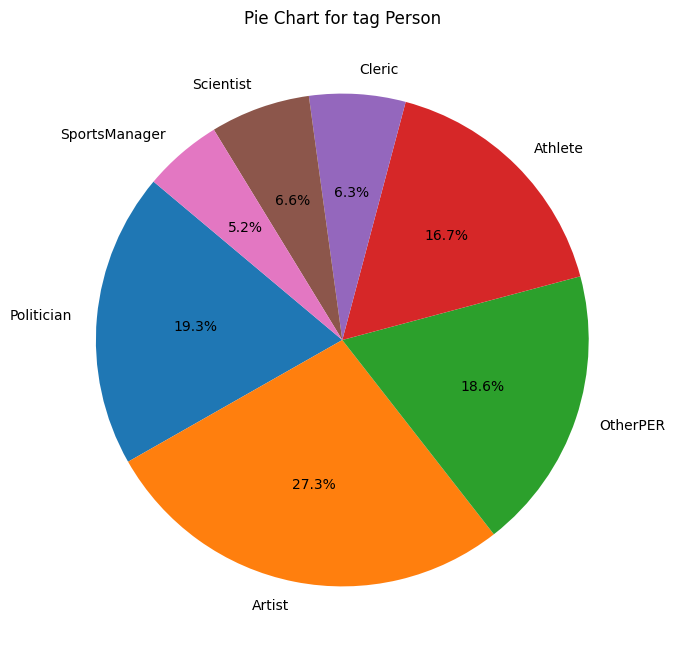

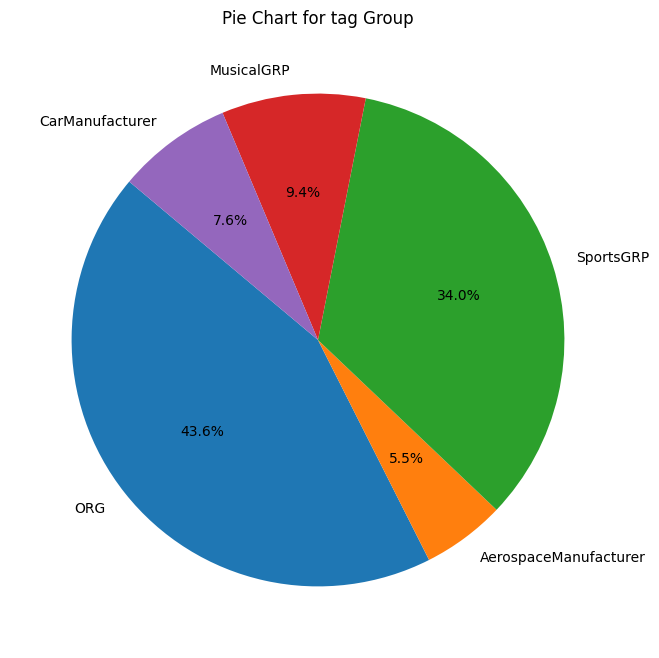

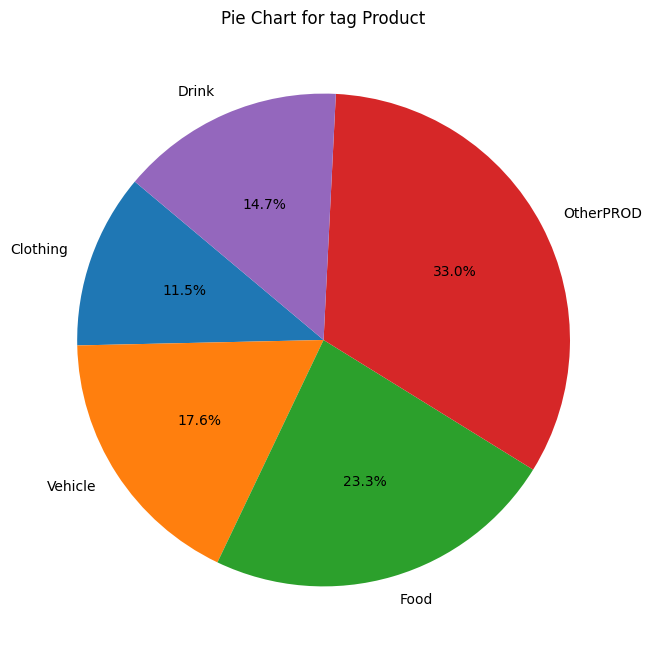

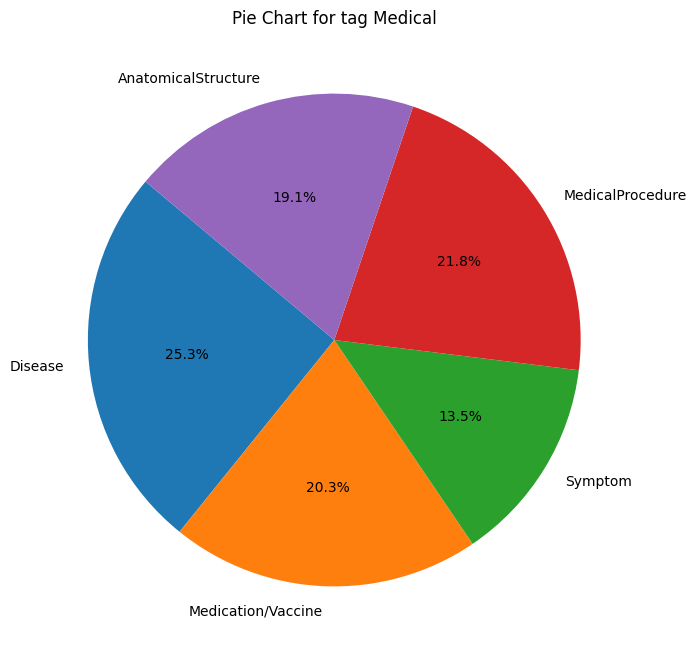

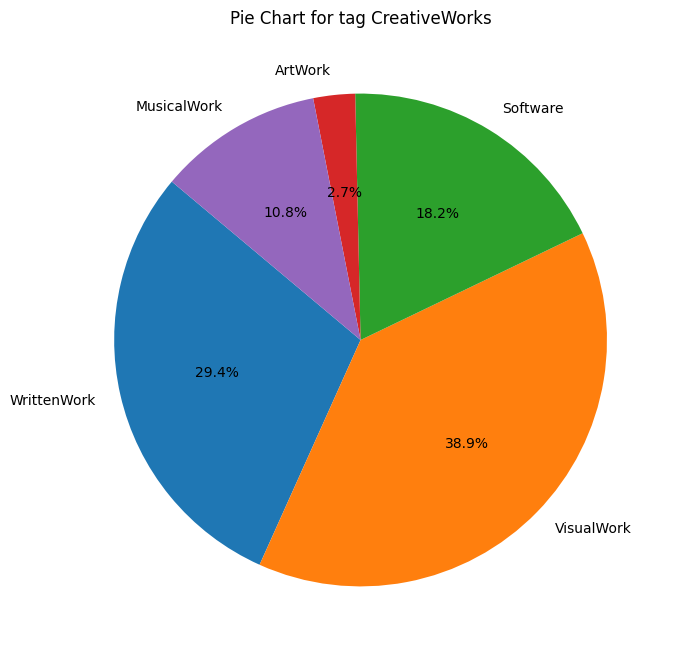

In [46]:
import matplotlib.pyplot as plt
count = {}
for index, row in df.iterrows():
    nerTags = list(row['ner_tags'])
    for index, ctag in enumerate(row['coarse_tags']):
        if(ctag!='O'):
            tag = ctag.split('-', 1)[1]
            nerTag = nerTags[index].split('-', 1)[1]
            if(tag in count.keys()):
                if(nerTag in count[tag]):
                    count[tag][nerTag]+=1
                else:
                    count[tag][nerTag]=1
            else:
                count[tag] = dict()
                count[tag][nerTag]=1
                
for ctag in count.keys():
    # Extract the keys and values from the dictionary
    labels = list(count[ctag].keys())
    sizes = list(count[ctag].values())

    # Create a pie chart
    plt.figure(figsize=(8, 8))  # Optional: Set the size of the figure
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

    # Optional: Add a title
    plt.title(f'Pie Chart for tag {ctag}')

    # Display the chart
    plt.show()


In [47]:
# sentences -> map of string (fine-tag): 
# vector<string> (vector of sentences which have atleast this fine-tag)
sentences = dict()
for index, row in df.iterrows():
    string = row['tokens']
    lastTag = 'O'
    for tag in row['ner_tags']:
        if(tag!='O'):
            refinedTag = tag.split('-')[1]
            if refinedTag != lastTag:
                if refinedTag in sentences.keys():
                    # we are taking atmost 10 sentences for each fine-tag
                    if len(sentences[refinedTag])<=10:
                        sentences[refinedTag].append((string, (list(row['ner_tags']), list(row['coarse_tags']))))
                else:
                    sentences[refinedTag] = [(string, (list(row['ner_tags']), list(row['coarse_tags'])))]
            lastTag = refinedTag

sentences.keys()

dict_keys(['HumanSettlement', 'Politician', 'ORG', 'OtherLOC', 'Facility', 'Artist', 'Station', 'OtherPER', 'Clothing', 'Disease', 'AerospaceManufacturer', 'Medication/Vaccine', 'WrittenWork', 'Vehicle', 'SportsGRP', 'Food', 'OtherPROD', 'VisualWork', 'MusicalGRP', 'CarManufacturer', 'Athlete', 'Software', 'Cleric', 'Symptom', 'ArtWork', 'Scientist', 'PublicCorp', 'PrivateCorp', 'SportsManager', 'MedicalProcedure', 'MusicalWork', 'Drink', 'AnatomicalStructure'])

In [48]:
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [49]:
import requests
import json
import os

openai_api_key = 'sk-proj-ySKbt0LjkitE4ts4P0t5T3BlbkFJldSueTrgUzo4BC2iDPwu'
if openai_api_key is None:
    raise ValueError("OpenAI API key is not set in environment variables.")

url = "https://api.openai.com/v1/chat/completions"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai_api_key}"
}

In [50]:
possibleFineForCoarse = {}

for key, value in replacement_mapping.items():
    if value not in possibleFineForCoarse:
        possibleFineForCoarse[value] = set()  # Initialize with an empty set if not present
    possibleFineForCoarse[value].add(key)

# this function generates LF from GPT based on the flag
# flag -> fullSentence/contextBased

def generateLFsFromGPT(sentence, fineLables, coarseLabels, targetLabel, flag):
    listOfIndices = []
    for index, word in enumerate(sentence):
        if targetLabel not in fineLables[index]:
            coarseLabels[index] = 'O'
    
    gptPrompt = dict()
    gptPrompt['fullSentence'] = f"""
                    Please write a labelling function for the fine label {targetLabel} 
                    for the following hindi sentence, whose coarse labels have also been 
                    provided. This coarse label may have many other fine labels under it, 
                    the list of possible fine labels against the coarse label is also given.
                    You have to create a labelling function that takes into account the context
                    of whole sentence and find the fine label that fits best to this coarse label.
                    Don't hardcode based off one sentence, since another test sentence can
                    easily beat the hardcoded labelling function.
                    sentence: {sentence},
                    coarse labels: {coarseLabels},
                    possible fine labels for the coarse label: {possibleFineForCoarse[replacement_mapping[targetLabel]]}
                    The labelling function should take in input the sentence list, the coarse 
                    label list, and should return a list where each entry is either 'O' or {targetLabel}.
                    Only provide the python code, and nothing else in conversation for the LF, without any formatting done through `
                """
    gptPrompt['contextBased'] = f"""
                    Please write a labelling function for the fine label {targetLabel} 
                    for the following hindi sentence, whose coarse labels have also been 
                    provided. This coarse label may have many other fine labels under it, 
                    the list of possible fine labels against the coarse label is also given.
                    You have to create a labelling function that takes into account the context
                    of size three on either side of the labelled NER and find the fine label that 
                    fits best to this coarse label. Don't hardcode based off one sentence, 
                    since another test sentence can easily beat the hardcoded 
                    labelling function.
                    sentence: {sentence},
                    coarse labels: {coarseLabels},
                    possible fine labels for the coarse label: {possibleFineForCoarse[replacement_mapping[targetLabel]]}
                    The labelling function should take in input the sentence list, the coarse 
                    label list, and should return a list where each entry is either 'O' or {targetLabel}.
                    Only provide the python code, and nothing else in conversation for the LF, without any formatting done through `
                """
    
    data = {
        "model": "gpt-4",
        "messages": [
            {
                "role": "system",
                "content": "Helpful assistant"
            },
            {
                "role": "user",
                "content": gptPrompt[flag]
            }
        ]
    }

    response = requests.post(url, headers=headers, json=data)

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content']
    else:
        error_info = response.json()  # Get error details from the response body
        error_message = error_info.get('error', {}).get('message', 'Unknown error')
        return f"Error {response.status_code}: {error_message}"

In [55]:
pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 2.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [67]:
from groq import Groq

def generateLFsFromLLaMa(sentence, fineLables, coarseLabels, targetLabel, flag):
    listOfIndices = []
    for index, word in enumerate(sentence):
        if targetLabel not in fineLables[index]:
            coarseLabels[index] = 'O'
    
    LLaMaPrompt = dict()
    LLaMaPrompt['fullSentence'] = f"""
                    Please write a labelling function for the fine label {targetLabel} 
                    for the following hindi sentence, whose coarse labels have also been 
                    provided. This coarse label may have many other fine labels under it, 
                    the list of possible fine labels against the coarse label is also given.
                    You have to create a labelling function that takes into account the context
                    of whole sentence and find the fine label that fits best to this coarse label.
                    Don't hardcode based off one sentence, since another test sentence can
                    easily beat the hardcoded labelling function.
                    sentence: {sentence},
                    coarse labels: {coarseLabels},
                    possible fine labels for the coarse label: {possibleFineForCoarse[replacement_mapping[targetLabel]]}
                    The labelling function should take in input the sentence list, the coarse 
                    label list, and should return a list where each entry is either 'O' or {targetLabel}.
                    Only provide the python code, and nothing else in conversation for the LF, without any formatting done through `
                """
    LLaMaPrompt['contextBased'] = f"""
                    Please write a labelling function for the fine label {targetLabel} 
                    for the following hindi sentence, whose coarse labels have also been 
                    provided. This coarse label may have many other fine labels under it, 
                    the list of possible fine labels against the coarse label is also given.
                    You have to create a labelling function that takes into account the context
                    of size three on either side of the labelled NER and find the fine label that 
                    fits best to this coarse label. Don't hardcode based off one sentence, 
                    since another test sentence can easily beat the hardcoded 
                    labelling function.
                    sentence: {sentence},
                    coarse labels: {coarseLabels},
                    possible fine labels for the coarse label: {possibleFineForCoarse[replacement_mapping[targetLabel]]}
                    The labelling function should take in input the sentence list, the coarse 
                    label list, and should return a list where each entry is either 'O' or {targetLabel}.
                    Only provide the python code, and nothing else in conversation for the LF, without any formatting done through `
                """
    
    client = Groq(
        api_key="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",
    )
    
    completion = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {
                "role": "user",
                "content": LLaMaPrompt[flag]
            },
            {
                "role": "assistant",
                "content": LLaMaPrompt[flag]
            }
        ],
        temperature=1,
        max_tokens=1024,
        top_p=1,
        stream=False,
        stop=None,
    )
    return completion.choices[0].message.content

In [ ]:
# sentenceToLFDict -> holds the two LFs corresponding to the sentence generated by GPT
sentenceToLFDict = dict()

for targetLabel in sentences:
    collectionOfSentences = sentences[targetLabel]
    for sentence, labels in collectionOfSentences:
        fineLabels = labels[0]
        coarseLabels = labels[1]
        if(targetLabel == 'PublicCorp'):
            targetLabel = 'PublicCORP'
        elif(targetLabel == 'PrivateCorp'):
            targetLabel = 'PrivateCORP'
        fullSentenceLF = generateLFsFromLLaMa(sentence, fineLabels, coarseLabels, targetLabel, 'fullSentence')
        contextBasedLF = generateLFsFromLLaMa(sentence, fineLabels, coarseLabels, targetLabel, 'contextBased')
        sentenceToLFDict[' '.join(sentence)] = [fullSentenceLF, contextBasedLF]
    break

file_path = "/kaggle/working/sentenceToLFDict.txt"
with open(file_path, "w", encoding="utf-8") as file:
    json.dump(sentenceToLFDict, file, ensure_ascii=False)

print(f"Dictionary saved to {file_path}")